In [2]:
pip install binsreg

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------------------------------- -------- 1.0/1.3 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 7.5 MB/s  0:00:00

   ------------- -------------------------- 1/3 [plotnine]
   ------------- -------------------------- 1/3 [plotnine]
   ------------- -------------------------- 1/3 [plotnine]
   ------------- -------------------------- 1/3 [plotnine]
   ---------------------------------------- 3/3 [binsreg]

Note: you may need to restart the kernel to use updated packages.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34972\1726183495.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34972\1726183495.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


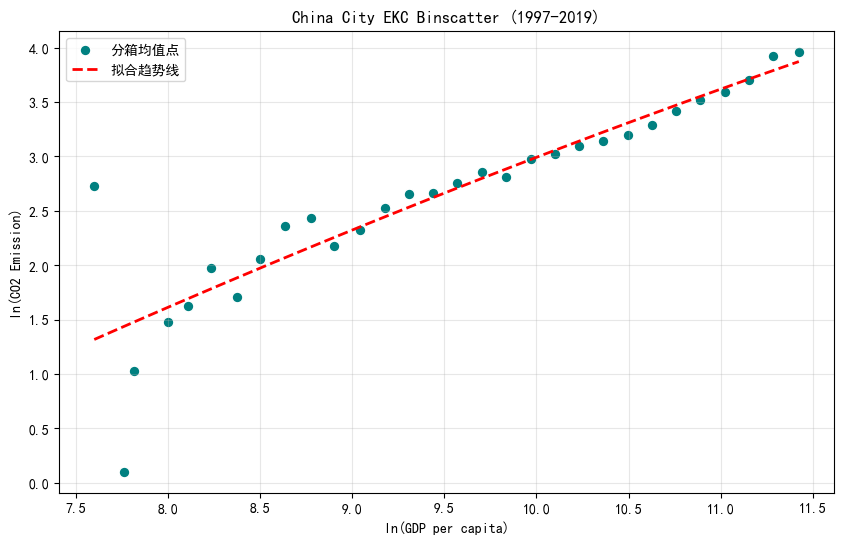

二次项系数为: -0.0208 (如果 > 0 则是开口向上)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from binsreg import binsreg

# 1. 读取你整合后的数据
df = pd.read_excel(r"C:\Users\Lenovo\Desktop\数据.xlsx")

# 2. 检查列名是否存在（防止拼写/全角半角括号问题）
# 打印列名确认一下：print(df.columns)
col_x = 'LN（人均GDP）'
col_y = 'LN（碳排放）'

# 3. 数据清洗：强制转换为数值并去空
df[col_x] = pd.to_numeric(df[col_x], errors='coerce')
df[col_y] = pd.to_numeric(df[col_y], errors='coerce')
df_clean = df.dropna(subset=[col_x, col_y])
df_clean = df_clean[df_clean[col_x] < 11.5]

# 4. 解决“空白图”：先创建一个显式的 figure
fig, ax = plt.subplots(figsize=(10, 6))

# 手动分箱：使用等距分箱，避开等频分箱可能导致的报错
bins = np.linspace(df_clean[col_x].min(), df_clean[col_x].max(), 31)
df_clean['bin'] = pd.cut(df_clean[col_x], bins=bins)
bin_centers = df_clean.groupby('bin')[col_x].mean()
bin_means = df_clean.groupby('bin')[col_y].mean()

# 5. 绘图
ax.scatter(bin_centers, bin_means, color='teal', s=60, edgecolors='white', label='分箱均值点')

# 强制进行二次拟合
z = np.polyfit(bin_centers.dropna(), bin_means.dropna(), 2)
p = np.poly1d(z)
x_range = np.linspace(bin_centers.min(), bin_centers.max(), 100)
ax.plot(x_range, p(x_range), "r--", linewidth=2, label='拟合趋势线')

# 字体处理：如果还是空白，尝试去掉中文，改用英文标签
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial'] 
ax.set_xlabel('ln(GDP per capita)')
ax.set_ylabel('ln(CO2 Emission)')
ax.set_title('China City EKC Binscatter (1997-2019)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

print(f"二次项系数为: {z[0]:.4f} (如果 > 0 则是开口向上)")

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34972\35311084.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_34972\35311084.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


------------------------------
二次项系数 (a): -0.13393
验证结果：二次项系数为负，成功呈现【倒U型】曲线！
预测拐点出现在人均GDP约为: 156598.48 元
------------------------------


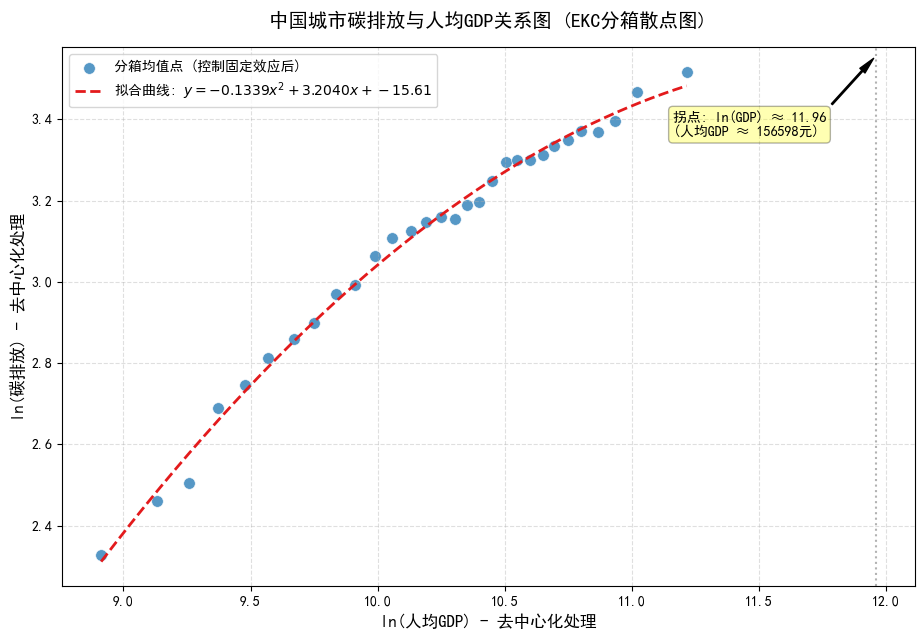

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ==========================================
# 1. 数据读取与编码修复
# ==========================================
file_path = r"C:\Users\Lenovo\Desktop\数据.xlsx"
for enc in ['gbk', 'utf-8-sig', 'gb18030']:
    try:
        df = pd.read_excel(file_path, encoding=enc)
        print(f"成功使用 {enc} 编码读取数据")
        break
    except:
        continue

# ==========================================
# 2. 数据清洗与变量准备
# ==========================================
# 定义列名（请确保与您的CSV列名完全一致，注意中文全角括号）
col_x = 'LN（人均GDP）'
col_y = 'LN（碳排放）'
col_raw_x = '人均GDP'

# 强制转换数值，处理可能存在的非数字字符
df[col_x] = pd.to_numeric(df[col_x], errors='coerce')
df[col_y] = pd.to_numeric(df[col_y], errors='coerce')

# 提取城市名称（从 'area_year' 提取非数字部分，用于去中心化）
df['city_name'] = df['area_year'].str.extract(r'([^\d]+)')

# 剔除极端值 (根据您之前的发现，ln_pgdp < 11.5 是合理范围)
df_clean = df[df[col_x] < 11.5].dropna(subset=[col_x, col_y, 'city_name'])

# ==========================================
# 3. 去中心化 (De-meaning) - 消除城市个体差异
# ==========================================
# 计算每个城市的均值
city_means = df_clean.groupby('city_name')[[col_x, col_y]].transform('mean')

# 执行去中心化：原始值 - 城市均值 + 全局均值（加全局均值是为了保持坐标轴刻度的物理意义）
df_clean['x_dem'] = df_clean[col_x] - city_means[col_x] + df_clean[col_x].mean()
df_clean['y_dem'] = df_clean[col_y] - city_means[col_y] + df_clean[col_y].mean()

# ==========================================
# 4. 分箱 (Binscatter) 逻辑
# ==========================================
num_bins = 30
# 使用等频分箱（每个箱子样本量相同）
df_clean['bin'] = pd.qcut(df_clean['x_dem'], q=num_bins, duplicates='drop')
bin_centers = df_clean.groupby('bin')['x_dem'].mean()
bin_means = df_clean.groupby('bin')['y_dem'].mean()

# ==========================================
# 5. 二次拟合与拐点计算
# ==========================================
# 拟合方程: y = ax^2 + bx + c
coeffs = np.polyfit(bin_centers, bin_means, 2)
p = np.poly1d(coeffs)

# 计算拐点: x = -b / 2a
turning_point_x = -coeffs[1] / (2 * coeffs[0])
turning_point_real_gdp = np.exp(turning_point_x)

# ==========================================
# 6. 绘图可视化
# ==========================================
plt.figure(figsize=(11, 7), dpi=100)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示
plt.rcParams['axes.unicode_minus'] = False 

# 画分箱均值点
plt.scatter(bin_centers, bin_means, color='#2c7fb8', s=70, alpha=0.8, 
            edgecolors='white', linewidth=0.5, label='分箱均值点 (控制固定效应后)')

# 画拟合曲线
x_range = np.linspace(bin_centers.min(), bin_centers.max(), 200)
plt.plot(x_range, p(x_range), color='#e31a1c', linestyle='--', linewidth=2, 
         label=f'拟合曲线: $y = {coeffs[0]:.4f}x^2 + {coeffs[1]:.4f}x + {coeffs[2]:.2f}$')

# 标注拐点
plt.axvline(x=turning_point_x, color='gray', linestyle=':', alpha=0.6)
plt.annotate(f'拐点: ln(GDP) ≈ {turning_point_x:.2f}\n(人均GDP ≈ {turning_point_real_gdp:.0f}元)', 
             xy=(turning_point_x, p(turning_point_x)), 
             xytext=(turning_point_x-0.8, p(turning_point_x)-0.2),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

# 美化图表
plt.title('中国城市碳排放与人均GDP关系图 (EKC分箱散点图)', fontsize=14, pad=15)
plt.xlabel('ln(人均GDP) - 去中心化处理', fontsize=12)
plt.ylabel('ln(碳排放) - 去中心化处理', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(loc='best')

# 结论输出
print("-" * 30)
print(f"二次项系数 (a): {coeffs[0]:.5f}")
if coeffs[0] < 0:
    print("验证结果：二次项系数为负，成功呈现【倒U型】曲线！")
    print(f"预测拐点出现在人均GDP约为: {turning_point_real_gdp:.2f} 元")
else:
    print("验证结果：二次项系数为正，呈现【正U型】。建议检查是否存在其他极端离群值。")
print("-" * 30)

plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28940\825154263.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[col_x], bins=bins)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28940\825154263.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bin'] = pd.cut(data[col_x], bins=bins)


PermissionError: [Errno 13] Permission denied: 'EKC_Evolution_Comparison.png'

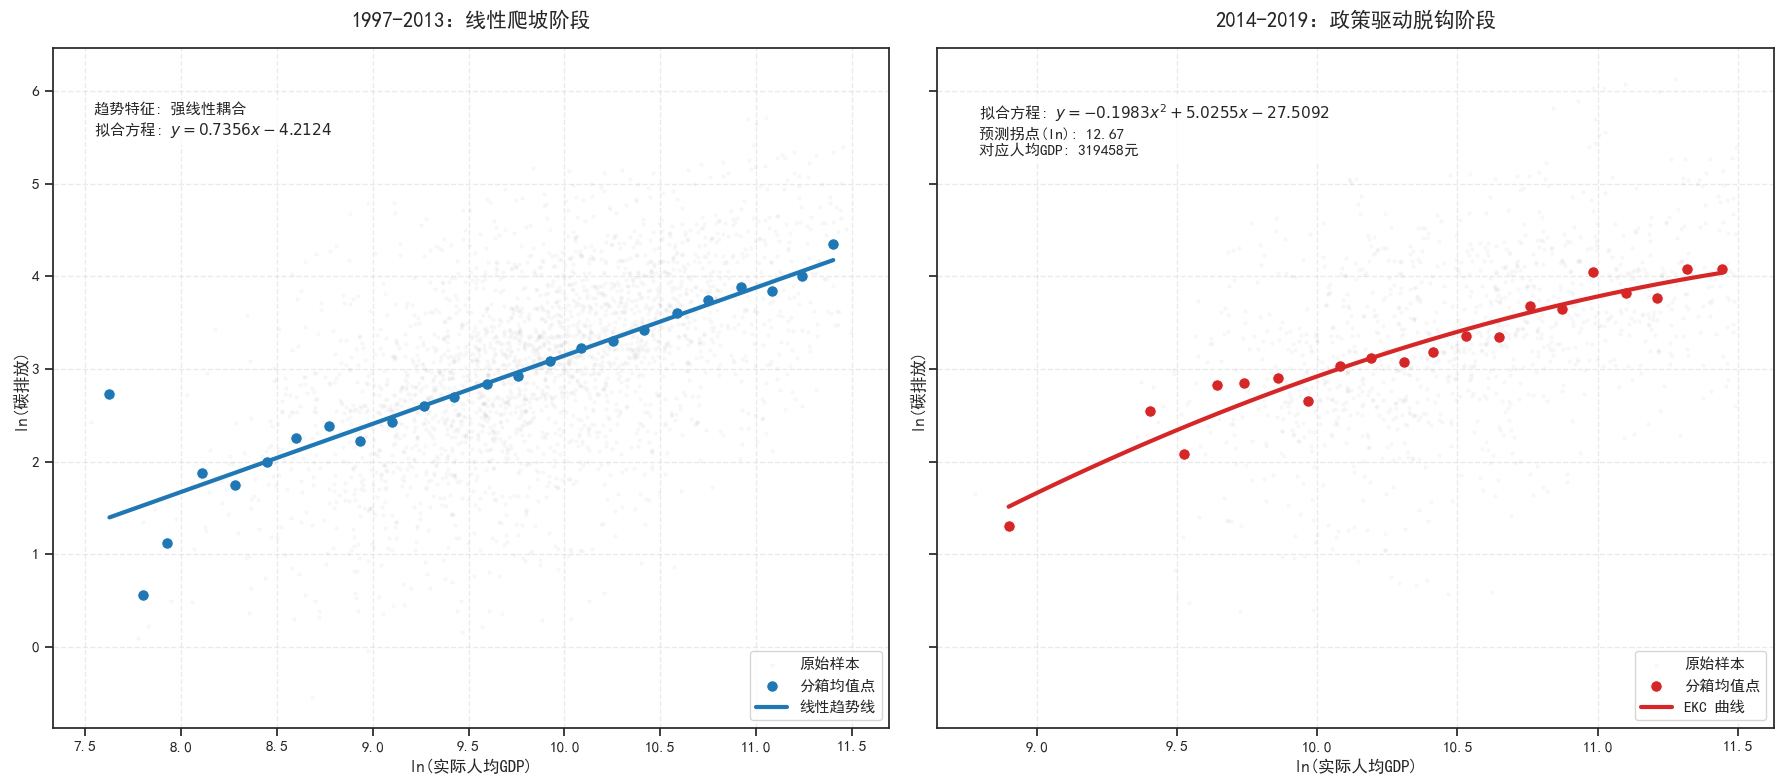

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== 数据读取与清洗 =====================
file_path = r"C:\Users\Lenovo\Desktop\全样本GDP平减结果_1997基准.xlsx"
df = pd.read_excel(file_path)

col_x = 'LN（实际人均GDP）'
col_y = 'LN（碳排放）'
year_col = '年份'

df_clean = df.dropna(subset=[col_x, col_y]).copy()
df_clean = df_clean[df_clean[col_x] < 11.5] # 剔除极值点

# 设置全局样式
sns.set_theme(style="ticks")
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False

# ===================== 定义绘图逻辑 =====================
def plot_mixed_ekc(ax, data, title, color, fit_type='quadratic'):
    # 1. 分箱处理
    bins = np.linspace(data[col_x].min(), data[col_x].max(), 25)
    data['bin'] = pd.cut(data[col_x], bins=bins)
    bin_centers = data.groupby('bin', observed=True)[col_x].mean()
    bin_means = data.groupby('bin', observed=True)[col_y].mean()
    
    # 2. 绘制背景散点和分箱点
    ax.scatter(data[col_x], data[col_y], color='gray', s=5, alpha=0.04, label='原始样本')
    ax.scatter(bin_centers, bin_means, color=color, s=70, edgecolors='white', linewidth=0.8, zorder=5, label='分箱均值点')
    
    # 3. 拟合逻辑
    valid_mask = ~bin_means.isna()
    x_v = bin_centers[valid_mask]
    y_v = bin_means[valid_mask]
    x_range = np.linspace(x_v.min(), x_v.max(), 100)
    
    if fit_type == 'linear':
        # 线性拟合: y = ax + b
        z = np.polyfit(x_v, y_v, 1)
        p = np.poly1d(z)
        y_fit = p(x_range)
        formula = f"$y = {z[0]:.4f}x {'+' if z[1]>0 else '-'} {abs(z[1]):.4f}$"
        info_text = f"趋势特征: 强线性耦合\n拟合方程: {formula}"
        ax.plot(x_range, y_fit, color=color, linewidth=3, label='线性趋势线', zorder=6)
        
    else:
        # 二次拟合: y = ax^2 + bx + c
        z = np.polyfit(x_v, y_v, 2)
        p = np.poly1d(z)
        y_fit = p(x_range)
        a, b, c = z[0], z[1], z[2]
        formula = f"$y = {a:.4f}x^2 {'+' if b>0 else '-'} {abs(b):.4f}x {'+' if c>0 else '-'} {abs(c):.4f}$"
        
        # 计算拐点
        tp_ln = -b / (2 * a)
        tp_real = np.exp(tp_ln)
        if a < 0:
            info_text = f"拟合方程: {formula}\n预测拐点(ln): {tp_ln:.2f}\n对应人均GDP: {tp_real:.0f}元"
            if x_range.min() < tp_ln < x_range.max() + 1: # 绘制预测线
                ax.axvline(x=tp_ln, color='orange', linestyle='--', alpha=0.7, label='预测达峰线')
        else:
            info_text = f"拟合方程: {formula}\n趋势结论: 边际增速放缓"
        ax.plot(x_range, y_fit, color=color, linewidth=3, label='EKC 曲线', zorder=6)

    # 4. 样式美化
    ax.set_title(title, fontsize=15, fontweight='bold', pad=15)
    ax.set_xlabel('ln(实际人均GDP)', fontsize=12)
    ax.set_ylabel('ln(碳排放)', fontsize=12)
    ax.text(0.05, 0.92, info_text, transform=ax.transAxes, fontsize=11, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='lower right')

# ===================== 生成对比图 =====================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharey=True)

# 13年前：线性
df_before = df_clean[(df_clean[year_col] >= 1997) & (df_clean[year_col] <= 2013)]
plot_mixed_ekc(ax1, df_before, '1997-2013：线性爬坡阶段', '#1f77b4', fit_type='linear')

# 13年后：二次
df_after = df_clean[(df_clean[year_col] >= 2014) & (df_clean[year_col] <= 2019)]
plot_mixed_ekc(ax2, df_after, '2014-2019：政策驱动脱钩阶段', '#d62728', fit_type='quadratic')

plt.tight_layout()
plt.savefig('EKC_Evolution_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_28940\1974568822.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  growth_rates = yearly_total.groupby('区域').apply(calc_aagr).reset_index()


PermissionError: [Errno 13] Permission denied: 'Three_Regions_Comparison.png'

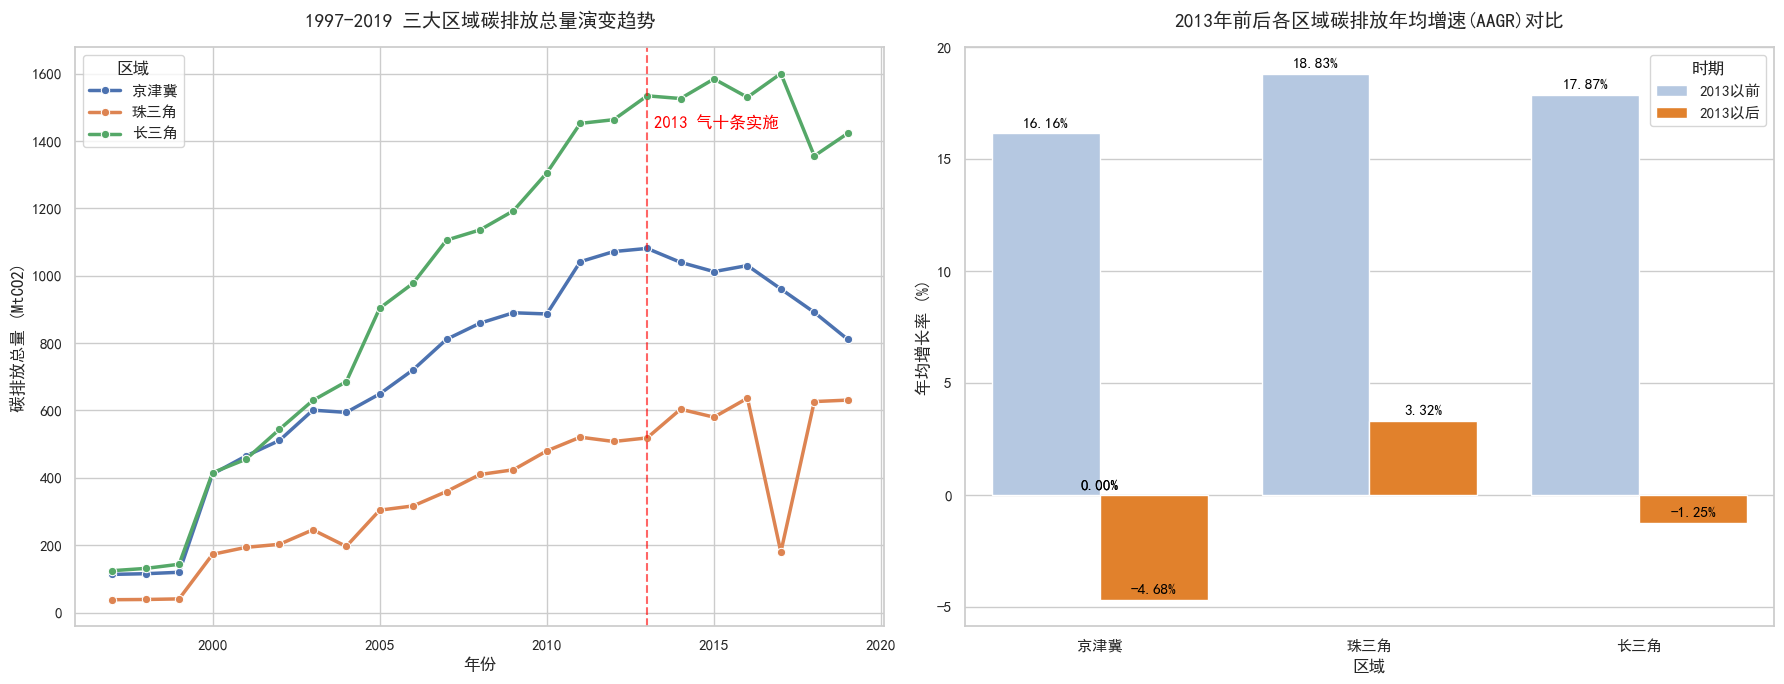

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===================== 1. 数据加载与预处理 =====================
file_path = r"C:\Users\Lenovo\Desktop\全样本GDP平减结果_1997基准.xlsx"
df = pd.read_excel(file_path)

# 定义三大区域范围
jjj_provinces = ['北京', '天津', '河北']
yrd_provinces = ['上海', '江苏', '浙江']

prd_cities = ['广州', '深圳', '珠海', '佛山', '江门', '肇庆', '惠州', '东莞', '中山']

def assign_region(row):
    if row['所属省份'] in jjj_provinces:
        return '京津冀'
    if row['所属省份'] in yrd_provinces:
        return '长三角'
    if row['所属省份'] == '广东':
        return '珠三角'
    return '其他'

df['区域'] = df.apply(assign_region, axis=1)
df_regions = df[df['区域'] != '其他'].copy()



# ===================== 2. 统计总量与计算增速 =====================
# A. 计算年度总量
yearly_total = df_regions.groupby(['年份', '区域'])['碳排放'].sum().reset_index()

# B. 计算分阶段年均增长率 (AAGR)
# 阶段1: 1997-2012 | 阶段2: 2013-2019
def calc_aagr(group):
    # 计算公式: ((末期值/初期值)^(1/n) - 1) * 100
    def get_rate(sub_df):
        start_val = sub_df.iloc[0]['碳排放']
        end_val = sub_df.iloc[-1]['碳排放']
        n = sub_df['年份'].max() - sub_df['年份'].min()
        return ((end_val / start_val) ** (1/n) - 1) * 100 if n > 0 else 0

    before = get_rate(group[group['年份'] <= 2012].sort_values('年份'))
    after = get_rate(group[group['年份'] >= 2013].sort_values('年份'))
    return pd.Series({'2013以前': before, '2013以后': after})

growth_rates = yearly_total.groupby('区域').apply(calc_aagr).reset_index()
# 转换为长格式以便绘图
growth_melted = growth_rates.melt(id_vars='区域', var_name='时期', value_name='年均增长率(%)')

# ===================== 3. 可视化绘制 =====================
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", font='SimHei')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# --- 图1: 总量对比折线图 ---
sns.lineplot(data=yearly_total, x='年份', y='碳排放', hue='区域', 
             marker='o', markersize=6, linewidth=2.5, ax=ax1)
ax1.axvline(x=2013, color='red', linestyle='--', alpha=0.6)
ax1.text(2013.2, yearly_total['碳排放'].max()*0.9, '2013 气十条实施', color='red', fontweight='bold')
ax1.set_title('1997-2019 三大区域碳排放总量演变趋势', fontsize=14, pad=15)
ax1.set_ylabel('碳排放总量 (MtCO2)')
ax1.set_xlabel('年份')

# --- 图2: 增速对比柱状图 ---
sns.barplot(data=growth_melted, x='区域', y='年均增长率(%)', hue='时期', 
            palette=['#aec7e8', '#ff7f0e'], ax=ax2)
ax2.set_title('2013年前后各区域碳排放年均增速(AAGR)对比', fontsize=14, pad=15)
ax2.set_ylabel('年均增长率 (%)')
ax2.set_xlabel('区域')

# 在柱状图上添加数值标注
for p in ax2.patches:
    ax2.annotate(f'{p.get_height():.2f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 7), 
                 textcoords='offset points')

plt.tight_layout()
plt.savefig('Three_Regions_Comparison.png', dpi=300)
plt.show()

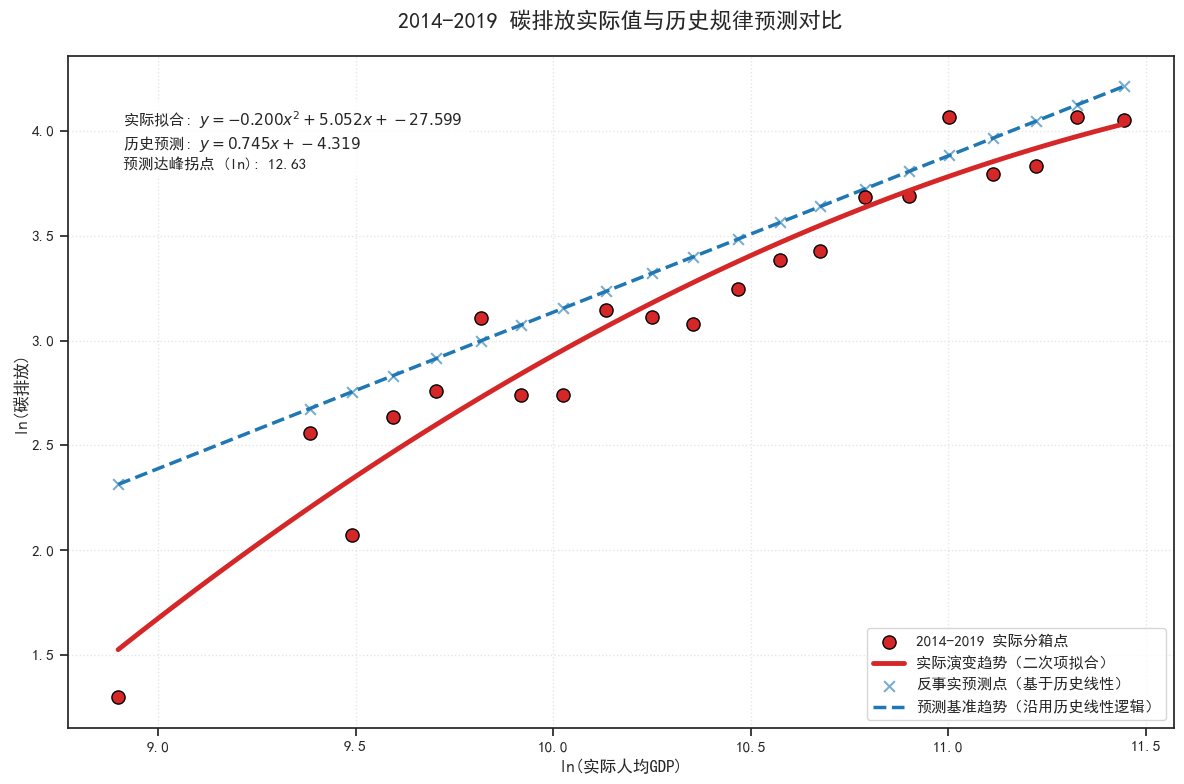

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# ===================== 1. 数据读取与预处理 =====================
file_path = r"C:\Users\Lenovo\Desktop\全样本GDP平减结果_1997基准.xlsx"
df = pd.read_excel(file_path)

col_x = 'LN（实际人均GDP）'
col_y = 'LN（碳排放）'
year_col = '年份'

df_clean = df.dropna(subset=[col_x, col_y]).copy()
df_clean = df_clean[df_clean[col_x] < 11.5]

# 划分为政策前（训练集）和政策后（评估集）
df_pre = df_clean[df_clean[year_col] <= 2013]
df_post = df_clean[df_clean[year_col] >= 2014].copy()

# ===================== 2. 机器学习：学习历史线性逻辑 =====================
# 模型学习 1997-2013 的排放规律
model = RandomForestRegressor(n_estimators=500, random_state=42)
model_history.fit(df_pre[[col_x]], df_pre[col_y])

# 预测 2014-2019 在“无政策干预”下的反事实排放
df_post['Predict_Y_Linear'] = model_history.predict(df_post[[col_x]])

# ===================== 3. 数据分箱（为了图像整洁） =====================
def get_binned_data(data, target_y):
    # 按 GDP 等距分 25 个箱子
    bins = np.linspace(data[col_x].min(), data[col_x].max(), 26)
    data['bin'] = pd.cut(data[col_x], bins=bins)
    binned = data.groupby('bin', observed=True).agg({col_x: 'mean', target_y: 'mean'}).dropna()
    return binned

# 获取 2014-2019 的实际分箱和预测分箱
bin_actual = get_binned_data(df_post, col_y)
bin_predict = get_binned_data(df_post, 'Predict_Y_Linear')

# ===================== 4. 绘图：实际二次曲线 vs 历史线性预测 =====================
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(12, 8))

# --- 绘制实际观测数据（2014-2019）：执行二次拟合 ---
plt.scatter(bin_actual[col_x], bin_actual[col_y], color='#d62728', s=90, 
            edgecolors='black', label='2014-2019 实际分箱点', zorder=5)

z_actual = np.polyfit(bin_actual[col_x], bin_actual[col_y], 2)
p_actual = np.poly1d(z_actual)
x_range = np.linspace(bin_actual[col_x].min(), bin_actual[col_x].max(), 100)
plt.plot(x_range, p_actual(x_range), color='#d62728', linewidth=3.5, 
         label='实际演变趋势（二次项拟合）', zorder=6)

# --- 绘制反事实预测（2014-2019）：执行线性拟合 ---
# 注意：这里我们直接展示机器学习预测出来的线性关系
plt.scatter(bin_predict[col_x], bin_predict['Predict_Y_Linear'], color='#1f77b4', 
            s=60, marker='x', alpha=0.6, label='反事实预测点（基于历史线性）', zorder=4)

z_pred = np.polyfit(bin_predict[col_x], bin_predict['Predict_Y_Linear'], 1)
p_pred = np.poly1d(z_pred)
plt.plot(x_range, p_pred(x_range), color='#1f77b4', linewidth=2.5, 
         linestyle='--', label='预测基准趋势（沿用历史线性逻辑）', zorder=3)

# ===================== 5. 标注与信息呈现 =====================
# 计算拐点（如果 a < 0）
a, b, c = z_actual[0], z_actual[1], z_actual[2]
turning_point = -b / (2 * a)

formula_act = f"实际拟合: $y = {a:.3f}x^2 + {b:.3f}x + {c:.3f}$"
formula_pre = f"历史预测: $y = {z_pred[0]:.3f}x + {z_pred[1]:.3f}$"

# 在图上标注
plt.text(0.05, 0.92, f"{formula_act}\n{formula_pre}\n预测达峰拐点 (ln): {turning_point:.2f}", 
         transform=plt.gca().transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('2014-2019 碳排放实际值与历史规律预测对比', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('ln(实际人均GDP)', fontsize=12)
plt.ylabel('ln(碳排放)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()